<a href="https://colab.research.google.com/github/lleviraz/urban_segmentation/blob/main/notebooks/NB1_Exporting_S2_Batch_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<h1>Google Earth Engine Image Export </h1>

## Connecting GEE with Google Services

**Note** that the earthengine-api is `'beta'`!!!

In [22]:
#earth-engine Python API
!pip install earthengine-api -q
!pip install rasterio -q

In [23]:
import rasterio as rio
from rasterio.transform import Affine
from rasterio.plot import show_hist,show
from tqdm.notebook import tqdm
import os
import ee
ee.__version__

'0.1.316'

- **Authenticate to Google Drive**


In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Authenticate to Earth Engine**

In [25]:
# UPLOAD the file '/content/ee-liadleviraz-6b395913b972.json'
# from google.colab import auth
# auth.authenticate_service_account()
!earthengine authenticate --auth_mode notebook

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=_Z_lMvABycnxAEzyJoa7CZdq3PZtNQJx4BaKOsWN7TM&tc=phfdnggP7rIiUmzomNUqQY_EKTYfy6BCPRI7mPVGnOg&cc=dDAsAXaT3pfOt6cOVWwHo8-GtoJUIKuQc5mO1unDK7k

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AdQt8qjsonU3H1M0DC2sdoJocfaHgnZ5yHyrRz2qYnpzCI8SktrPaHsfMxs

Successfully saved authorization token.


## Initiate the API

In [26]:
# Earth Engine Python API
ee.Initialize()

In [ ]:
# import ee 
# #TODO ORIGINAL S2 export we used in training
# # replace this with Yoavs image collection ABOVE
# # The Training_grid was prepared by Yoav
# table = ee.FeatureCollection("users/yoavpld/ML/Training_grid")

# def maskS2clouds(image):
#   qa = image.select('QA60')
#   # Bits 10 and 11 are clouds and cirrus, respectively.
#   cloudBitMask = 1 << 10
#   cirrusBitMask = 1 << 11

#   # Both flags should be set to zero, indicating clear conditions.
#   mask = qa.bitwiseAnd(cloudBitMask).eq(0) \
#       .And(qa.bitwiseAnd(cirrusBitMask).eq(0))
  
#   #the values are high originally
#   return image.updateMask(mask).divide(10000)

# BANDS = ['B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']
# print(len(BANDS),' bands selected')

# dataset = ee.ImageCollection('COPERNICUS/S2_SR') \
#                   .filterDate('2019-01-01', '2020-01-30') \
#                   .map(lambda x: x.clip(table)) \
#                   .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',1)) \
#                   .map(maskS2clouds)
# dataset = dataset.select(BANDS)

# visualization = {
#   'min': 0.0,
#   'max': 0.3,
#   'bands': ['B4', 'B3', 'B2'],
# }

# n_list = ee.List(ee.Feature(table))
# print(n_list)

# # ee.mapclient.addToMap(dataset.mean(), visualization, 'RGB')

# # ee.mapclient.addToMap(fc, {}, 'Grid')

# The export function (Run from here...)

In [27]:
def doExport(dataset,region,img_ID,gee_export_dir,block=True):
  """Runs the image export task.  Block until complete."""
  task = ee.batch.Export.image.toDrive(**{
    'image': dataset.mean(),
    'description': 'Export_S2_Image',
    # 'scale': 10,
    'dimensions': '300x300',
    'region': region['coordinates'],
    'fileNamePrefix':'s2_img_'+str(img_ID),
    'folder':gee_export_dir,
    'crs':'EPSG:3857'
    }
  )
  task.start()

  if(block):
    print('Exporting image to Drive...')
    # Block until the task completes.
    import time
    while task.active():
      time.sleep(5)
      # print('Polling for task (id: {}).'.format(task.id))

    # Error condition
    if task.status()['state'] != 'COMPLETED':
      print('Error with image export (check:https://code.earthengine.google.com/tasks)')
    else:
      print('Image export completed.')
  else:
    # print('Started background export of image to Drive...')
    return task

In [28]:
#Set this asset as the source for exporting 300x300 images
# table = ee.FeatureCollection("users/yoavpld/ML/Training_grid")
# table = ee.FeatureCollection("users/yoavpld/ML/Saitama_grid")
table = ee.FeatureCollection("users/yoavpld/ML/Saitama_3000m_grid_EPSG6677")

# Set the image collection

In [12]:
#This is the new Image Collection of the S2 (1M images !!!)
import ee
# import geemap
# Map = geemap.Map()

#Original training dataset was with '2019-01-01', '2020-01-30'
# load the S2 dataset
# S2_summer2018 = ee.ImageCollection('COPERNICUS/S2') \ #Yoav sent this !!! but originallay we used S2_SR!!! 
S2_summer2018 = ee.ImageCollection('COPERNICUS/S2_SR')\
           .filterDate("2018-01-01", "2018-12-31") \
           .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5)); 

# load S2_CLOUD_PROBABILITY dataset
S2_CLOUD_PROBABILITY = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')

# Join S2_summer2018 and S2_CLOUD_PROBABILITY
S2withCloudMask = ee.Join.saveFirst('cloud_mask').apply(
                  S2_summer2018,S2_CLOUD_PROBABILITY,
                  ee.Filter.equals(leftField= 'system:index',rightField= 'system:index')        
                  )
    
S2withCloudMask = ee.ImageCollection(S2withCloudMask)

# # define a function to mask-out clouds from each image
def maskClouds(img):
  clouds = ee.Image(img.get('cloud_mask')).select('probability')
  isNotCloud = clouds.lt(20)
  return img.mask(isNotCloud).divide(10000) #TODO the divide was added by ME - solves "black squares"!!!

# # use the maskClouds function
S2_summer2018_cloudsMasked = S2withCloudMask.map(maskClouds)

#MY ADDITION
BANDS = ['B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']
print(len(BANDS),' bands selected')
dataset = S2_summer2018_cloudsMasked.select(BANDS)


# Map

EEException: ignored

# run the export process in the background (on GEE servers)

In [13]:
%%time

import datetime,random
from tqdm.notebook import tqdm

t = datetime.datetime.today()
export_dir='gee_export' + '_'+ t.strftime('%h_%d_%Y_%H%M')
DRIVE_PREFIX='/content/drive/MyDrive/'
!mkdir -p {DRIVE_PREFIX}{export_dir}

tasks = []
# SELECTED = [204,480,689,185,528,218,215,509,388,640,543,424,433,66,100,200,300,400]
# SELECTED = random.sample(range(1, 700), 200)	
# print(SELECTED)
# SELECTED = [204,66]
print('Exporting images to {} (background)...'.format(export_dir))
features = table.getInfo()['features']
for img in tqdm(features):
  try:
    img_id = img['properties']['ID']
  except:
    img_id = img['properties']['id']
  # print(img)
  geom = img['geometry']
  # if img_id in SELECTED:
  tasks.append(doExport(dataset,geom,img_id,export_dir,block=False))

Exporting images to gee_export_Jul_18_2022_1436 (background)...


NameError: ignored

In [ ]:
#Sequential export of images
# %%time

# from tqdm.notebook import tqdm
# for img in tqdm(fc.getInfo()['features'][:15]):
#   img_id = img['properties']['ID']
#   print('image:',img_id)
#   fc11 = ee.Geometry.Polygon(img['geometry']['coordinates'])
#   doExport2(dataset,fc11,img_id)

# 700 images take ~2 hours with the free account

In [ ]:
%%time

import time
errs=0
for task in tqdm(tasks):
  while task.active():
    time.sleep(5)

  # Error condition
  if task.status()['state'] != 'COMPLETED':
    errs+=1
    print('Error with image export.')
  else:
    # print('Image export completed.')
    pass

print('{} images exported to {}, {} failed.)'.format(len(tasks)-errs,export_dir,errs))

  0%|          | 0/49 [00:00<?, ?it/s]

49 images exported to gee_export_Jul_14_2022_1601, 0 failed.)
CPU times: user 3.96 s, sys: 458 ms, total: 4.42 s
Wall time: 8min 14s


In [ ]:
print('letting drive sync files....')
time.sleep(10)

letting drive sync files....


In [14]:
import os
from pathlib import Path

path = Path(DRIVE_PREFIX+export_dir)
files = [f for f in path.iterdir()]
files[:3]

[]

In [ ]:
SAMPLE_IMAGE = Path(files[0])

In [17]:
def normalize(image,vmin=0.0,vmax=0.3):
  '''
  RGB data was exported in the range between 0 and 0.3
  '''
  return (image - vmin)/(vmax-vmin)

def display_image(image_path,bands=[3,2,1],title=None,ax=None,vmin=0.0,vmax=0.3):
  '''
  Displaying RBG images by Red,Green,Blue in this order
  '''
  img =  rio.open(image_path)
  print(img)
  show(normalize(img.read(bands),vmin=vmin,vmax=vmax), title=title,ax=ax)
  # print(title,len(img.indexes),'bands')
  return img

In [41]:
def print_image_metadata(rasterio_img,title=None):
  print(title + ' Metadata:',rasterio_img.meta)
  print(title + ' Transform:\n',rasterio_img.transform)

In [5]:
import matplotlib.pyplot as plt

for i,f in tqdm(enumerate(files[:5])):
  img1=display_image(f,title=f.name)
  print_image_metadata(img1,img1.name)

NameError: ignored

A good example

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<open DatasetReader name='/content/drive/MyDrive/gee_export_Jul_14_2022_1601/s2_img_1.tif' mode='r'>
/content/drive/MyDrive/gee_export_Jul_14_2022_1601/s2_img_1.tif Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 300, 'height': 300, 'count': 11, 'crs': CRS.from_epsg(3857), 'transform': Affine(12.379094069612522, 0.0, 15533706.569938207,
       0.0, -12.433727354093765, 4300933.988254617)}
/content/drive/MyDrive/gee_export_Jul_14_2022_1601/s2_img_1.tif Transform:
 | 12.38, 0.00, 15533706.57|
| 0.00,-12.43, 4300933.99|
| 0.00, 0.00, 1.00|
<open DatasetReader name='/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/S2/R_5_428.tif' mode='r'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/S2/R_5_428.tif Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 301, 'height': 302, 'count': 11, 'crs': CRS.from_epsg(3857), 'transform': Affine(10.0, 0.0, 931300.0,
       0.0, -10.0, 6277857.007733986)}
/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/S2/R_5_428.tif Transform:
 | 10.00, 0.00, 931300.00|
| 0.00,-10.00, 6277857.01|
| 0.00, 0.00, 1.00|


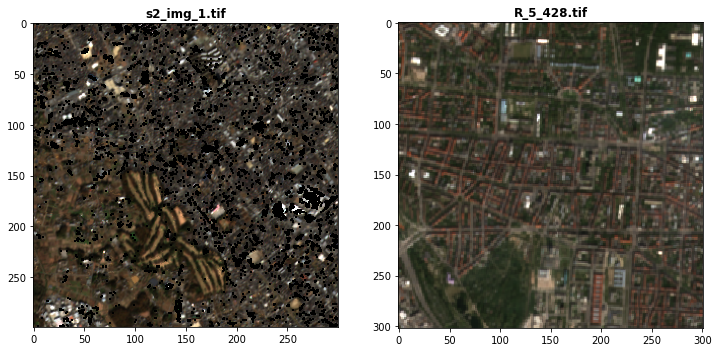

In [ ]:
f,axs=plt.subplots(1,2,figsize=(12,30))
NEW_IMG = Path(files[1])
REF_IMAGE = Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/S2/R_5_428.tif')

img0=display_image(NEW_IMG,title=NEW_IMG.name,ax=axs[0])
print_image_metadata(img0,img0.name)

print('===============================')
img2=display_image(REF_IMAGE,title=REF_IMAGE.name,ax=axs[1])
print_image_metadata(img2,img2.name)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<open DatasetReader name='/content/drive/MyDrive/gee_export_Jul_14_2022_1601/s2_img_4.tif' mode='r'>
/content/drive/MyDrive/gee_export_Jul_14_2022_1601/s2_img_4.tif Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 300, 'height': 300, 'count': 11, 'crs': CRS.from_epsg(3857), 'transform': Affine(12.366348287009945, 0.0, 15533739.7584226,
       0.0, -12.421005204984297, 4289777.620314759)}
/content/drive/MyDrive/gee_export_Jul_14_2022_1601/s2_img_4.tif Transform:
 | 12.37, 0.00, 15533739.76|
| 0.00,-12.42, 4289777.62|
| 0.00, 0.00, 1.00|
<open DatasetReader name='/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/S2/R_7_688.tif' mode='r'>
/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/S2/R_7_688.tif Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 301, 'height': 302, 'count': 11, 'crs': CRS.from_epsg(3857), 'transform': Affine(10.0, 0.0, 1498300.0,
       0.0, -10.0, 6877856.45518784)}
/content/drive/MyDrive/2022/S1/36

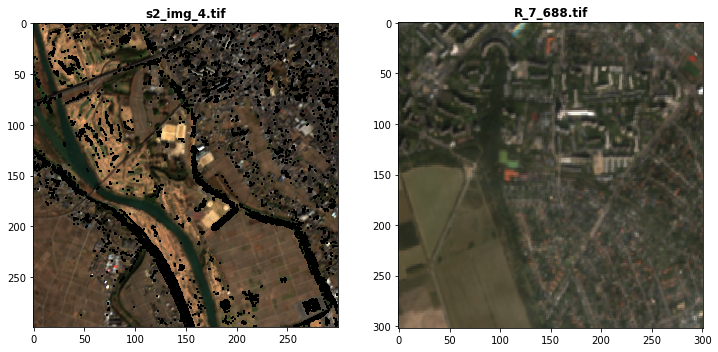

In [ ]:
f,axs=plt.subplots(1,2,figsize=(12,6))
NEW_IMG = Path(files[2])
REF_IMAGE = Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/S2/R_7_688.tif')

img3=display_image(NEW_IMG,title=NEW_IMG.name,ax=axs[0])
print_image_metadata(img3,img3.name)
# print(img3.read(range(1,12)))
print('===============================')
img4=display_image(REF_IMAGE,title=REF_IMAGE.name,ax=axs[1])
print_image_metadata(img4,img4.name)

In [ ]:
import glob as glob
list_of_files = filter( os.path.isfile,
                        glob.glob(DRIVE_PREFIX+export_dir+'/*.tif', recursive=True) )
# Sort list of files in directory by size 
list_of_files = sorted( list_of_files,
                        key =  lambda x: os.stat(x).st_size)


In [ ]:
print('nan exported files (size 29KB):')
!mkdir -p {export_dir}_failed
for file in list_of_files[:30]:
  fsize=os.stat(file).st_size
  if(fsize==29262):
    print(file,fsize)
    shutil.move(file, export_dir +'_failed')

print('Any failed exported images were moved to:',export_dir +'_failed')

nan exported files (size 29KB):
Any failed exported images were moved to: gee_export_Jul_14_2022_1601_failed


In [ ]:
import numpy as np
np.array(img0.read(1)),np.array(img2.read(1))


(array([[0.0513 , 0.04045, 0.03885, ..., 0.0266 , 0.04915, 0.0775 ],
        [0.0386 , 0.0355 , 0.0466 , ..., 0.04375, 0.0542 , 0.0658 ],
        [0.0393 , 0.049  , 0.0657 , ..., 0.04905, 0.0455 , 0.04205],
        ...,
        [0.01855, 0.02375, 0.0289 , ..., 0.1    ,     nan, 0.0802 ],
        [0.02405, 0.03645, 0.02935, ..., 0.0485 , 0.0437 ,     nan],
        [0.04155, 0.0379 , 0.0318 , ..., 0.0418 ,     nan, 0.0407 ]],
       dtype=float32),
 array([[0.05829362, 0.04595957, 0.04535319, ..., 0.04389574, 0.04174681,
         0.04174681],
        [0.05829362, 0.04595957, 0.04535319, ..., 0.04389574, 0.04174681,
         0.04174681],
        [0.05315958, 0.05881277, 0.05001489, ..., 0.04127872, 0.03500425,
         0.03500425],
        ...,
        [0.0653383 , 0.0653383 , 0.08970851, ..., 0.03270851, 0.0315851 ,
         0.04491064],
        [0.05551915, 0.05551915, 0.07142979, ..., 0.03587447, 0.0394234 ,
         0.04522979],
        [0.05551915, 0.05551915, 0.07142979, ..., 0.0358

##Export to drive:
1. Specify the Sentinel tile, which we already defined
2. Name your export
3. Specify the folder where you want to store your export
4. Set the scale of the export
5. Specify the region we want to export (note: this can be any polygon, but in this case we use a rectangular box)
6. Set the desired output CRS
7. Set the desired output filetype

## Zooming in on a single image end2end

We can see this is in Saitama area , approx 3000x3000 (around $5km^2$)

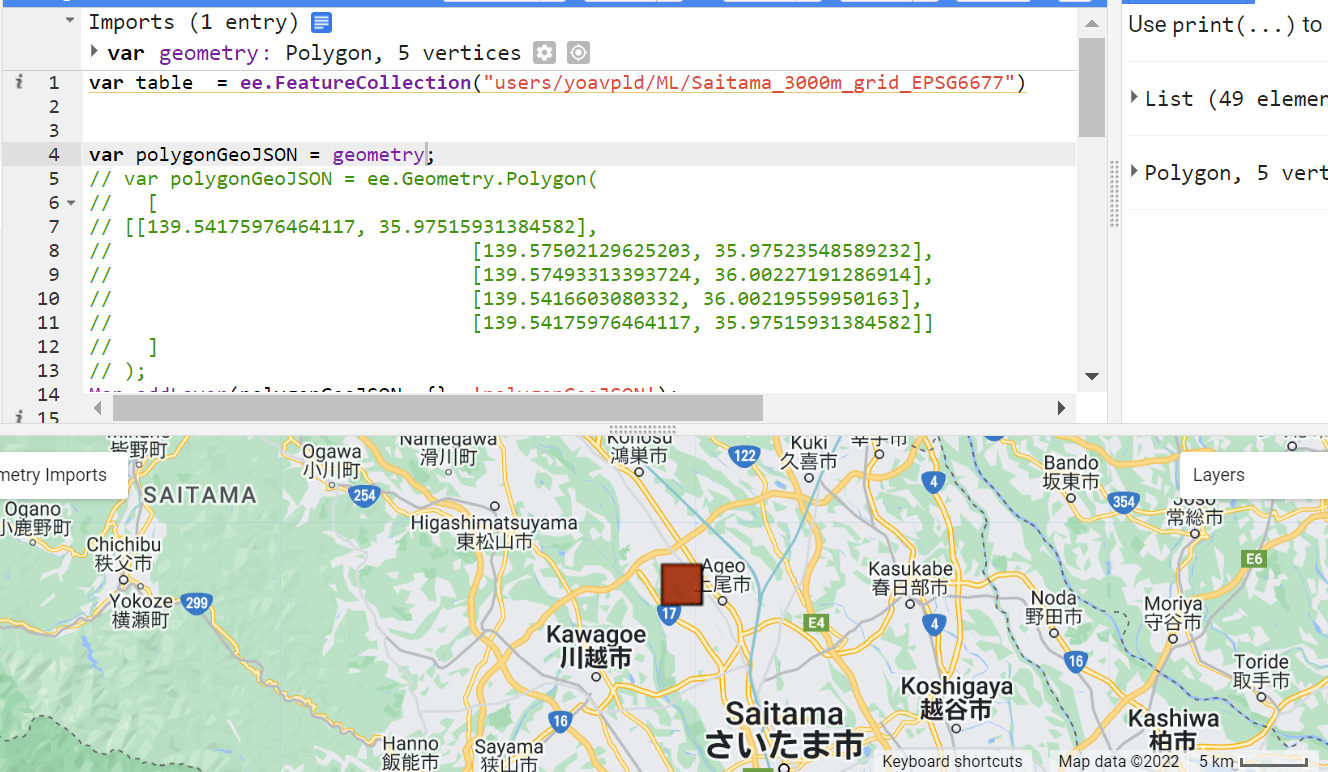

In [38]:
from pprint import pprint
for fff in table.getInfo()['features']:
  if (fff['properties']['id']==1):
    pprint(fff)

{'geometry': {'coordinates': [[[139.54175976464117, 35.97515931384582],
                               [139.57502129625203, 35.97523548589232],
                               [139.57493313393724, 36.00227191286914],
                               [139.5416603080332, 36.00219559950163],
                               [139.54175976464117, 35.97515931384582]]],
              'type': 'Polygon'},
 'id': '00000000000000000000',
 'properties': {'id': 1},
 'type': 'Feature'}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<open DatasetReader name='/content/drive/MyDrive/gee_export_Jul_14_2022_1601/s2_img_19.tif' mode='r'>
/content/drive/MyDrive/gee_export_Jul_14_2022_1601/s2_img_19.tif Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 300, 'height': 300, 'count': 11, 'crs': CRS.from_epsg(3857), 'transform': Affine(12.35584207093964, 0.0, 15541149.160996607,
       0.0, -12.410551389915248, 4286078.8619571095)}
/content/drive/MyDrive/gee_export_Jul_14_2022_1601/s2_img_19.tif Transform:
 | 12.36, 0.00, 15541149.16|
| 0.00,-12.41, 4286078.86|
| 0.00, 0.00, 1.00|
<open DatasetReader name='/content/drive/MyDrive/gee_export_Jul_14_2022_1601_prep/s2_img_19.tif' mode='r'>
/content/drive/MyDrive/gee_export_Jul_14_2022_1601_prep/s2_img_19.tif Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 300, 'height': 300, 'count': 15, 'crs': CRS.from_epsg(3857), 'transform': Affine(12.35584207093964, 0.0, 15541149.160996607,
       0.0, -12.410551389915248, 4286078.8619571095

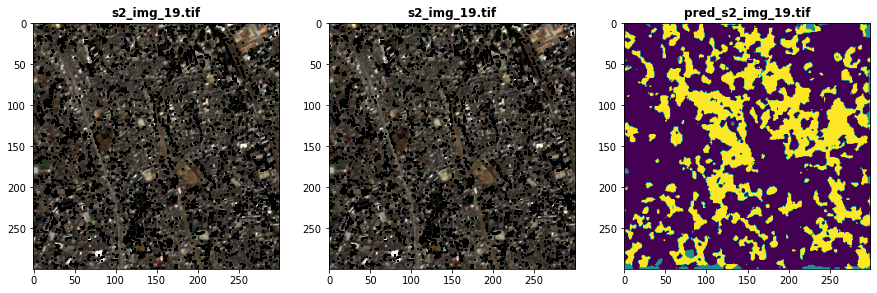

In [88]:
f,axs=plt.subplots(1,3,figsize=(15,6))
# IMG_01 = 's2_img_1.tif'
IMG_01 = 's2_img_19.tif'
downloaded_img1 = Path('/content/drive/MyDrive/gee_export_Jul_14_2022_1601/'+IMG_01)
preprocessed_img1 = Path('/content/drive/MyDrive/gee_export_Jul_14_2022_1601_prep/'+IMG_01)
pred_mask1 = Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/saitama_preds_jul18/pred_'+IMG_01)

d_img_01=display_image(downloaded_img1,title=downloaded_img1.name,ax=axs[0])
print_image_metadata(d_img_01,d_img_01.name)
print('===============================')
p_img_01=display_image(preprocessed_img1,title=preprocessed_img1.name,ax=axs[1])
print_image_metadata(p_img_01,p_img_01.name)
print('===============================')
p_msk_01=display_image(pred_mask1,title=pred_mask1.name,ax=axs[2],bands=[1])
print_image_metadata(p_msk_01,p_msk_01.name)
assert(p_img_01.meta['transform']==p_msk_01.meta['transform'])
assert(p_img_01.meta['crs']==p_msk_01.meta['crs'])

## 2 good ones from Test Preds

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<open DatasetReader name='/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/S2/R_1_88.tif' mode='r'>
/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/S2/R_1_88.tif Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 301, 'height': 301, 'count': 11, 'crs': CRS.from_epsg(3857), 'transform': Affine(10.0, 0.0, 2443300.0,
       0.0, -10.0, 5314859.946144144)}
/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/S2/R_1_88.tif Transform:
 | 10.00, 0.00, 2443300.00|
| 0.00,-10.00, 5314859.95|
| 0.00, 0.00, 1.00|
<open DatasetReader name='/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized_test/R_1_88.tif' mode='r'>
/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized_test/R_1_88.tif Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 300, 'height': 300, 'count': 15, 'crs': CRS.from_epsg(3857), 'transform': Affine(10.0, 0.0, 2443300.0,
       0.0, -10.0, 5314859.946144144)}
/content/drive/MyDri

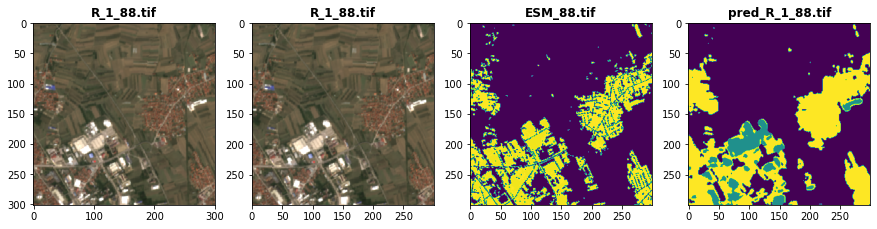

In [89]:
f,axs=plt.subplots(1,4,figsize=(15,6))
IMG_011 = 'R_1_88.tif'
downloaded_img1 = Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/S2/'+IMG_011)
preprocessed_img1 = Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized_test/'+IMG_011)
orig_mask1 = Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/esm_aligned_test/ESM_88.tif')
pred_mask1 = Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/esm_preds_jul18/pred_'+IMG_011)

d_img_01=display_image(downloaded_img1,title=downloaded_img1.name,ax=axs[0])
print_image_metadata(d_img_01,d_img_01.name)
print('===============================')
p_img_01=display_image(preprocessed_img1,title=preprocessed_img1.name,ax=axs[1])
print_image_metadata(p_img_01,p_img_01.name)
print('===============================')
o_msk_01=display_image(orig_mask1,title=orig_mask1.name,ax=axs[2],bands=[1])
print_image_metadata(o_msk_01,o_msk_01.name)
print('===============================')
p_msk_01=display_image(pred_mask1,title=pred_mask1.name,ax=axs[3],bands=[1])
print_image_metadata(p_msk_01,p_msk_01.name)
assert(p_img_01.meta['transform']==p_msk_01.meta['transform'])
assert(p_img_01.meta['crs']==p_msk_01.meta['crs'])
assert(o_msk_01.meta==p_msk_01.meta)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<open DatasetReader name='/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/S2/R_2_101.tif' mode='r'>
/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/S2/R_2_101.tif Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 301, 'height': 303, 'count': 11, 'crs': CRS.from_epsg(3857), 'transform': Affine(10.0, 0.0, 1765300.0,
       0.0, -10.0, 5743864.483211231)}
/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/S2/R_2_101.tif Transform:
 | 10.00, 0.00, 1765300.00|
| 0.00,-10.00, 5743864.48|
| 0.00, 0.00, 1.00|
<open DatasetReader name='/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized_test/R_2_101.tif' mode='r'>
/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized_test/R_2_101.tif Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 300, 'height': 300, 'count': 15, 'crs': CRS.from_epsg(3857), 'transform': Affine(10.0, 0.0, 1765300.0,
       0.0, -10.0, 5743864.483211231)}
/content/drive/

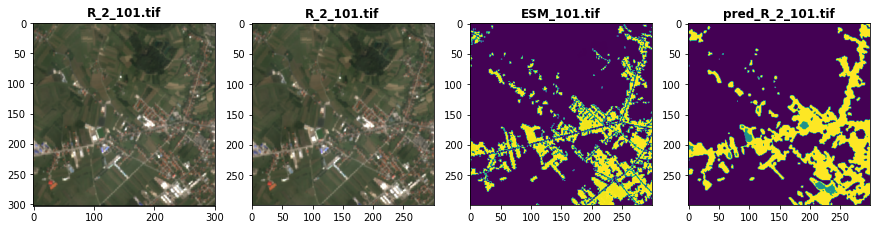

In [90]:
f,axs=plt.subplots(1,4,figsize=(15,6))
# IMG_01 = 'R_1_3.tif'
IMG_01 = 'R_2_101.tif'
downloaded_img1 = Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/S2/'+IMG_01)
preprocessed_img1 = Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized_test/'+IMG_01)
orig_mask1 = Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/esm_aligned_test/ESM_101.tif')
pred_mask1 = Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/esm_preds_jul18/pred_'+IMG_01)

d_img_01=display_image(downloaded_img1,title=downloaded_img1.name,ax=axs[0])
print_image_metadata(d_img_01,d_img_01.name)
print('===============================')
p_img_01=display_image(preprocessed_img1,title=preprocessed_img1.name,ax=axs[1])
print_image_metadata(p_img_01,p_img_01.name)
print('===============================')
o_msk_01=display_image(orig_mask1,title=orig_mask1.name,ax=axs[2],bands=[1])
print_image_metadata(o_msk_01,o_msk_01.name)
print('===============================')
p_msk_01=display_image(pred_mask1,title=pred_mask1.name,ax=axs[3],bands=[1])
print_image_metadata(p_msk_01,p_msk_01.name)
assert(p_img_01.meta['transform']==p_msk_01.meta['transform'])
assert(p_img_01.meta['crs']==p_msk_01.meta['crs'])
assert(o_msk_01.meta==p_msk_01.meta)